# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

#### Imports

In [1]:
from skipgram import SkipGram, SkipGramBatcher
import torch
import gc
import datetime
import pickle
import numpy as np
import pandas as pd

# for visualisation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#### Constants

In [2]:
# select whether to train model during this run or just load it from saved file
TRAIN = False

In [3]:
VOCAB_SIZE = 20000
BATCH_SIZE = 2048
EMBEDDINGS_DIM = 150
EPOCH_NUM = 2
WINDOW_SIZE = 2
LOGS_PERIOD = 50
MODEL_NAME = 'naive_sg'
np.random.seed(42)

#### select device

In [4]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

if device.__str__() == 'cpu':
    tensor_type = torch.LongTensor
else:
    tensor_type = torch.cuda.LongTensor

print('using device:', device)
print(f'using {tensor_type} type')

using device: cpu
using <class 'torch.LongTensor'> type


#### Load corpus into batcher

In [5]:
text = []
with open('./data/text8', 'r') as text8:
    text = text8.read().split()

# text = ['first', 'used', 'against', 'early', 'working', 'radicals', 'including', 'class', 'other']
batcher = SkipGramBatcher(corpus=text, vocab_size=VOCAB_SIZE,
                          batch_size=BATCH_SIZE, window_size=WINDOW_SIZE,
                          drop_stop_words=True)
# free memory
text = []
gc.collect()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/DrMatters/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0

#### Create and train model

In [6]:
if TRAIN:
    loss_history = []
    corpus_size = len(batcher._corpus_indexes)

    model = SkipGram(VOCAB_SIZE, EMBEDDINGS_DIM)
    model.to(device)
    loss_fun = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
if TRAIN:
    learning_started = datetime.datetime.now()

    cumulative_loss = 0
    for epoch in range(EPOCH_NUM):
        for i, (context, target) in enumerate(batcher):
            tensor_context = torch.from_numpy(context).type(tensor_type)
            tensor_target = torch.from_numpy(target).type(tensor_type)
            tensor_context.to(device)
            tensor_target.to(device)

            model.zero_grad()

            log_probs = model(tensor_context)
            loss = loss_fun(log_probs, tensor_target)
            loss.backward()
            optimizer.step()
            cumulative_loss += loss

            if i % LOGS_PERIOD == 0:
                print(f'loss on {(i * BATCH_SIZE / corpus_size) * 100:.1f}%:' + \
                      f'{(cumulative_loss / LOGS_PERIOD) :.7f}')
                loss_history.append(loss.data.cpu().item())
                cumulative_loss = 0
        
        
        # after every epoch we save:
                                    # the model
                                    # loss history
        learning_ended = datetime.datetime.now()
        learning_time = (learning_ended - learning_started).total_seconds()
        learning_ended = learning_ended.strftime("%H-%M %d-%m-%Y")

        torch.save(model, f'./models/{MODEL_NAME}(finished-{learning_ended})(epochs_completed-{epoch})(epoch_num-{EPOCH_NUM})' + \
                   f'(vocab-{VOCAB_SIZE})(batch-{BATCH_SIZE})' + \
                   f'(emb-{EMBEDDINGS_DIM})(wind-{WINDOW_SIZE})(consumed-{learning_time})'+ \
                   f'.pytorchmodel')

        with open(f'./data/loss/loss_{MODEL_NAME}(finished-{learning_ended})(epochs_completed-{epoch})(epoch_num-{EPOCH_NUM})' + \
                  f'(vocab-{VOCAB_SIZE})(batch-{BATCH_SIZE})' + \
                  f'(emb-{EMBEDDINGS_DIM})(wind-{WINDOW_SIZE})(consumed-{learning_time})'+ \
                  f'.pickle', 'wb') as f:
            pickle.dump(loss_history, f)
        print('Model saved succesfully')
        

    with open(f'./data/batcher/batcher(vocab-{VOCAB_SIZE})(batch-{BATCH_SIZE})' + \
           f'(wind-{WINDOW_SIZE})'+ \
           f'(learning_finished-{learning_ended}).pickle', 'wb') as f:
        pickle.dump(batcher, f)

It took 105 minutes to train model on cpu

#### Plotting loss

In [8]:
from utils import plot_moving_average

loss_file_location = './data/loss/loss_naive_sg(finished-09-43 06-03-2019)(epochs_completed-1)(epoch_num-2)(vocab-20000)(batch-2048)(emb-150)(wind-2)(consumed-637.447675).pickle'

with open(loss_file_location, 'rb') as f:
    loss_history = pickle.load(f)

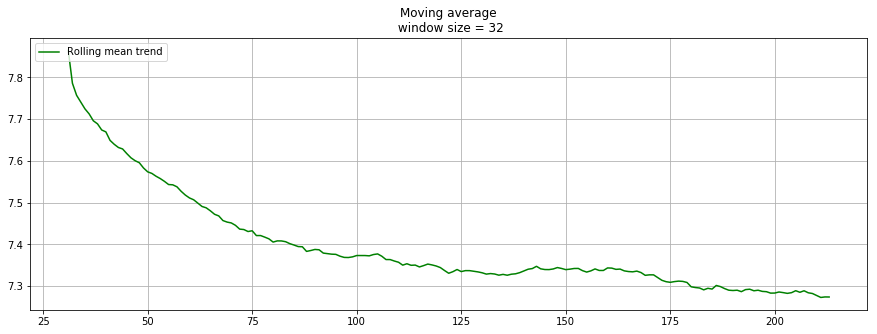

In [9]:
plot_moving_average(pd.Series(loss_history), 32, plot_actual=False)

#### Function to map token (and word) to corresponding word vector

In [10]:
from utils import EmbeddingsEval

model_file_location ='./models/naive_sg(finished-09-43 06-03-2019)(epochs_completed-1)(epoch_num-2)(vocab-20000)(batch-2048)(emb-150)(wind-2)(consumed-637.447675).pytorchmodel'
trained_model = torch.load(model_file_location, map_location='cpu')
trained_model

SkipGram(
  (embedding_layer): Embedding(20000, 150)
  (linear_layer): Linear(in_features=150, out_features=20000, bias=False)
  (activation): LogSoftmax()
)

In [11]:
intrinsic_matrix = trained_model.get_intrinsic_matrix()

emb_eval = EmbeddingsEval(intrinsic_matrix, words_to_tokens=batcher.words_to_tokens,
                          tokens_to_words=batcher.tokens_to_words)

In [12]:
emb_eval.tokens_to_embeddings([1, 2, 3])
emb_eval.words_to_embeddings(['integrity'])

array([[ 0.5559814 ,  0.5276517 , -0.0812892 , -0.56169313,  0.249352  ,
        -1.2795079 , -0.2675701 , -0.4201623 ,  0.26408643, -0.20710507,
        -0.3387416 ,  0.29534346,  0.3786333 , -1.0404819 ,  0.8046569 ,
         0.3740319 , -0.5667119 ,  0.06218451,  0.11631414,  0.42357147,
         0.07745802,  0.27466667,  0.3087733 , -0.04514068,  0.28072196,
        -0.03460099,  0.5315062 , -1.1309245 , -0.513701  ,  0.1569772 ,
         0.01662847, -0.02433327,  0.47650725,  0.33228016, -0.7861632 ,
        -0.9813427 ,  0.01356193, -0.66543156,  1.218454  , -0.9855783 ,
        -0.12431616, -0.00857601, -0.20192173, -0.2894689 , -0.06362651,
         0.33163762,  0.63268113, -0.30359167,  0.91266686,  0.5004358 ,
         0.76441133, -0.10806398, -0.39910048, -0.06823383, -0.06728312,
        -0.189141  , -0.41916502,  0.21530789, -0.4446152 , -0.3142494 ,
         0.47573858,  0.6975479 , -0.5367621 , -0.2287807 ,  0.12554869,
        -0.26253694, -0.34578106, -0.2552954 ,  0.2

#### Beautiful visualizations (PCA)

Take the most popular words

In [13]:
num_words = 200
words = batcher.tokens_to_words(np.arange(0, num_words))
embeddings = emb_eval.tokens_to_embeddings(np.arange(0, num_words))

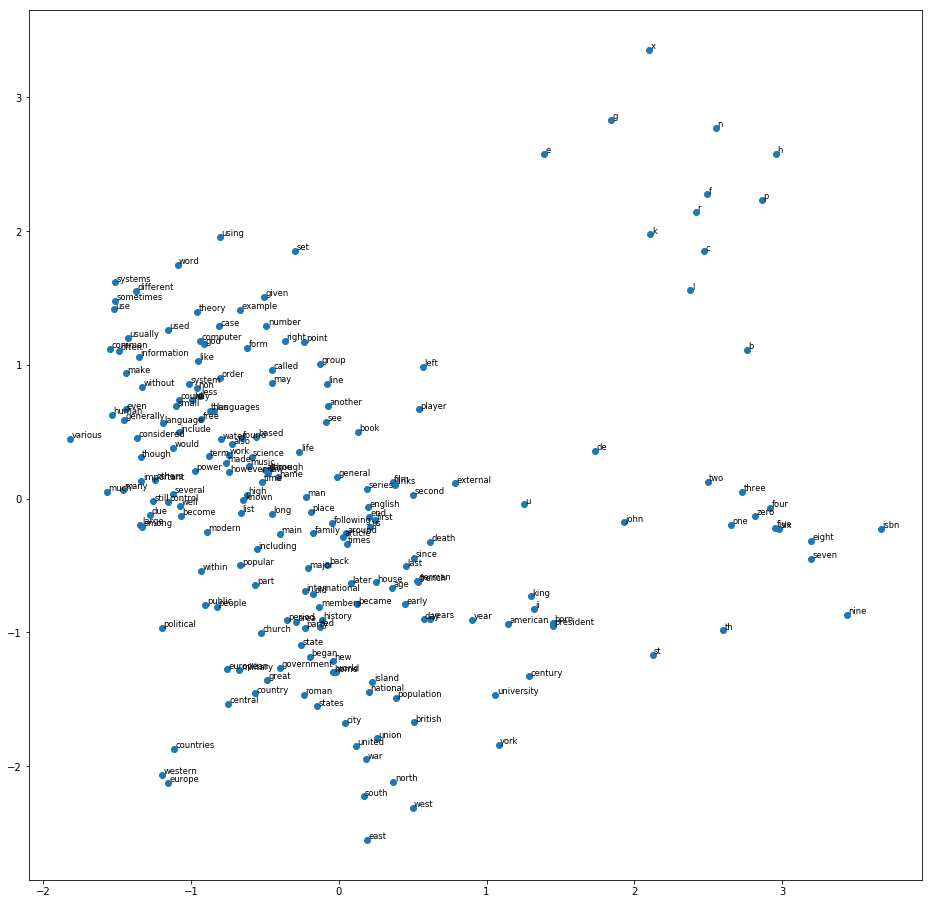

In [14]:
pca = PCA(n_components=2)
points2d = pca.fit_transform(embeddings)


fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter(points2d[:, 0], points2d[:, 1])

for i, word in enumerate(words):
    ax.annotate(word, (points2d[i, 0] + 0.01, points2d[i, 1] + 0.01), fontsize='small')

#### qualitative evaluations of word vectors: nearest neighbors, word analogies

In [18]:
for token_list in emb_eval.words_to_neighbors(['war', 'france', 'drink']):
    print(batcher.tokens_to_words(token_list))

['world', 'ii', 'battle', 'civil', 'fought']
['spain', 'germany', 'italy', 'netherlands', 'belgium']
['food', 'wine', 'drinks', 'beverage', 'eat']


In [16]:
similar = emb_eval.most_similar(positive=['france', 'berlin'], negative=['paris'])
similar

['berlin', 'germany', 'collapse', 'potential', 'substantial']